In [ ]:
pip install sgp4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.3/232.3 kB 6.1 MB/s eta 0:00:00


In [ ]:
pip install basemap basemap-data-hires


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 936.0/936.0 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.1/91.1 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.4 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully uninstalled packaging-24.1


Elementos Orbitais:
   Semi-eixo Maior Verdadeiro (km)  Semi-eixo Maior Estimado (km)  \
0                      6977.560588                    6978.206231   
1                      6977.560587                    6981.815819   
2                      6977.560585                    6979.902012   
3                      6977.560584                    6977.049223   
4                      6977.560583                    6977.693607   

   Diferença Semi-eixo Maior (km)  Excentricidade Verdadeira  \
0                       -0.645643                   0.001254   
1                       -4.255233                   0.001254   
2                       -2.341427                   0.001254   
3                        0.511361                   0.001254   
4                       -0.133024                   0.001254   

   Excentricidade Estimada  Diferença Excentricidade  \
0                 0.001294                 -0.000040   
1                 0.001329                 -0.000075   
2           

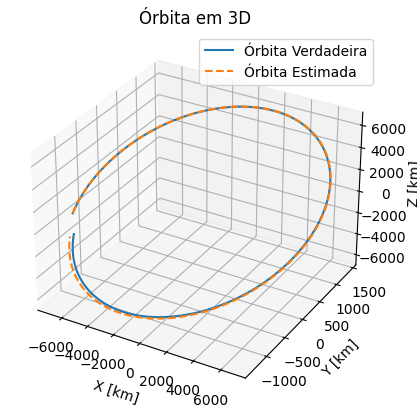

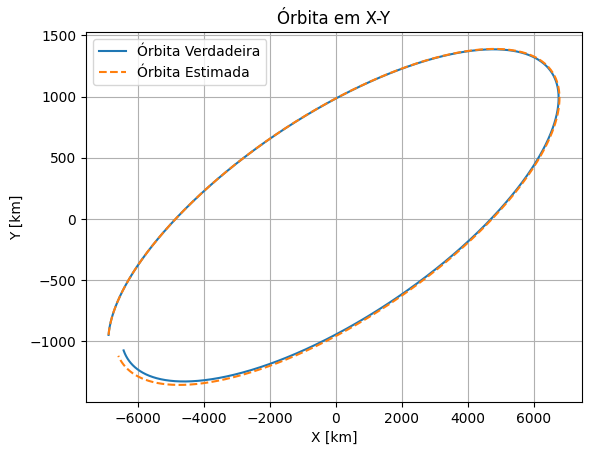

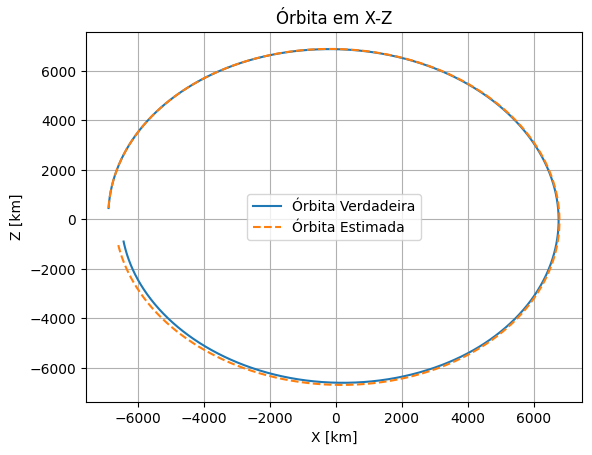

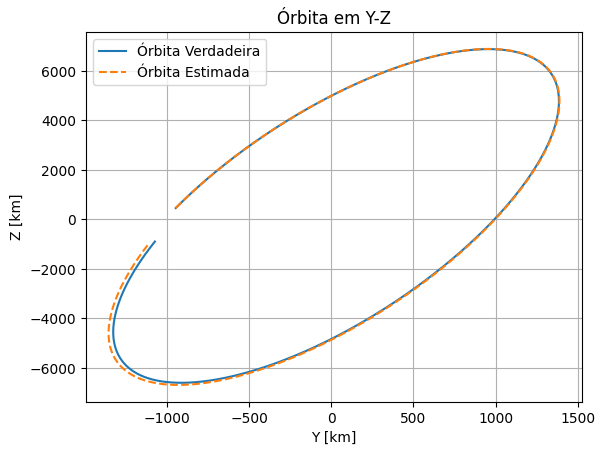

Tempo de execução: 39.0928430557251 segundos


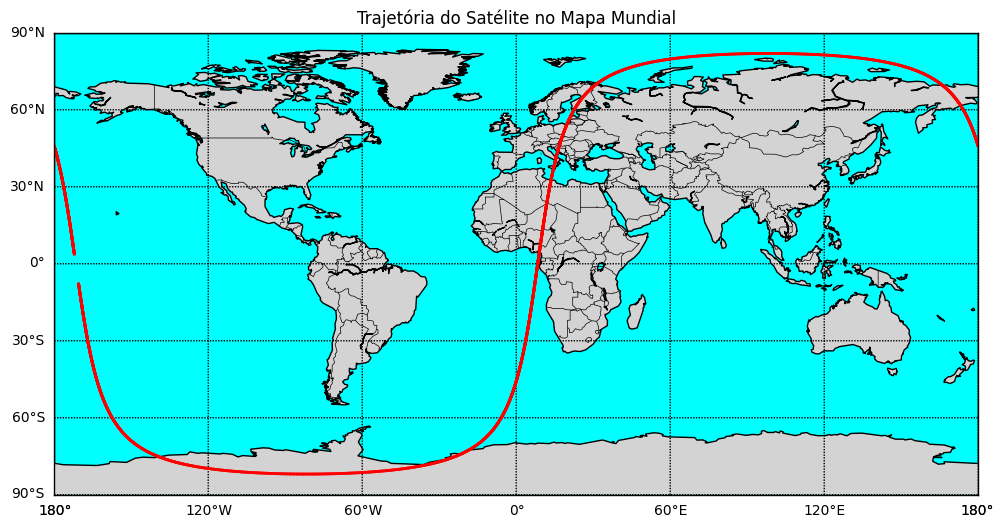

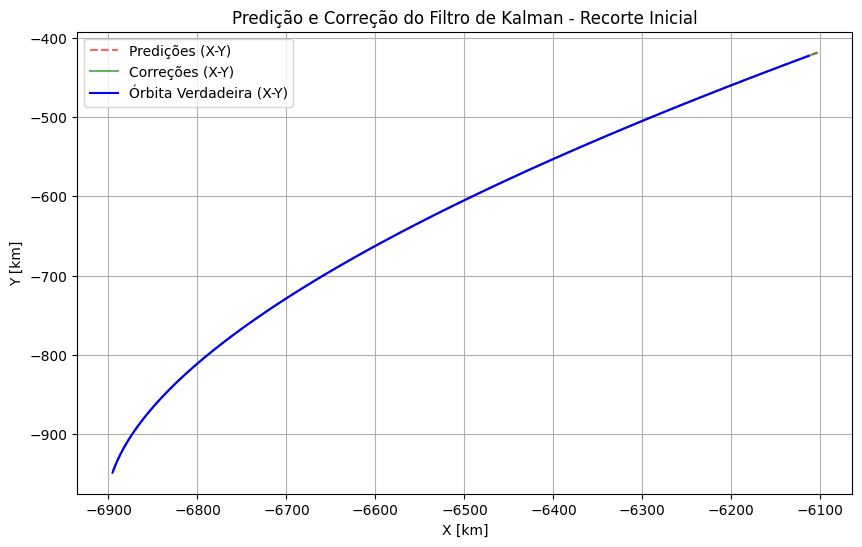

In [ ]:
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from scipy.linalg import cholesky
import pandas as pd
from sgp4.api import Satrec, jday
from datetime import datetime
import time
from mpl_toolkits.basemap import Basemap

start_time = time.time()
# Função para converter TLE para posição e velocidade inicial
def tle_to_state_vector(tle_line1, tle_line2, epoch):
    satellite = Satrec.twoline2rv(tle_line1, tle_line2)
    jd, fr = jday(epoch.year, epoch.month, epoch.day, epoch.hour, epoch.minute, epoch.second)
    e, r, v = satellite.sgp4(jd, fr)
    if e != 0:
        raise ValueError("Erro no cálculo da posição e velocidade a partir do TLE")
    return np.array(r), np.array(v)

# Parâmetros do problema (em km)
mu = 3.986004418e5  # Constante gravitacional da Terra [km^3/s^2]

tle_line1 = '1 40024U 14033Q   24231.47591853  .00022714  00000+0  15934-2 0  9994'
tle_line2 = '2 40024  98.0677 206.2510 0004330 341.9831  18.1240 15.05178164553135'

epoch = datetime(2023, 8, 18, 0, 0, 0)
r0, v0 = tle_to_state_vector(tle_line1, tle_line2, epoch)

# Funções de perturbação e dinâmica
def atmospheric_drag(v, r, Cd=2.2, A=20, m=500, rho=1e-12):
    v_rel = np.linalg.norm(v)
    drag_force = -0.5 * Cd * A * rho * v_rel * v / m
    return drag_force

def solar_radiation_pressure(r, A=20, m=500, Psr=4.5e-6):
    r_norm = np.linalg.norm(r)
    srp_force = Psr * A / m * r / r_norm
    return srp_force

def perturbed_dynamics(t, y):
    r = y[:3]
    v = y[3:]
    r_norm = np.linalg.norm(r)
    a_gravity = -mu * r / r_norm**3
    a_drag = atmospheric_drag(v, r)
    a_srp = solar_radiation_pressure(r)
    return np.hstack((v, a_gravity + a_drag + a_srp))

# Função para gerar pontos sigma
def generate_sigma_points(x, P, kappa):
    n = len(x)
    sigma_points = np.zeros((2 * n + 1, n))
    sigma_points[0] = x
    U = cholesky((n + kappa) * P)
    for i in range(n):
        sigma_points[i + 1] = x + U[i]
        sigma_points[n + i + 1] = x - U[i]
    return sigma_points

# Função de predição do UKF
def ukf_predict(sigma_points, dt):
    predicted_sigma_points = np.zeros_like(sigma_points)
    for i, sp in enumerate(sigma_points):
        sol = integrate.solve_ivp(perturbed_dynamics, (0, dt), sp, method='RK45')
        predicted_sigma_points[i] = sol.y[:, -1]
    return predicted_sigma_points

# Função de correção do UKF
def ukf_correct(sigma_points_pred, z_meas, R, kappa):
    n = len(sigma_points_pred[0])
    weights_mean = np.zeros(2 * n + 1)
    weights_cov = np.zeros(2 * n + 1)
    weights_mean[0] = kappa / (n + kappa)
    weights_cov[0] = weights_mean[0] + (1 - kappa)
    weights_mean[1:] = weights_cov[1:] = 1 / (2 * (n + kappa))

    x_pred = np.dot(weights_mean, sigma_points_pred)
    P_pred = np.zeros((n, n))
    for i in range(2 * n + 1):
        diff = sigma_points_pred[i] - x_pred
        P_pred += weights_cov[i] * np.outer(diff, diff)

    Z_pred = sigma_points_pred[:, :6]
    z_pred_mean = np.dot(weights_mean, Z_pred)
    P_zz = np.zeros((6, 6))
    for i in range(2 * n + 1):
        diff = Z_pred[i] - z_pred_mean
        P_zz += weights_cov[i] * np.outer(diff, diff)
    P_zz += R

    P_xz = np.zeros((n, 6))
    for i in range(2 * n + 1):
        P_xz += weights_cov[i] * np.outer(sigma_points_pred[i] - x_pred, Z_pred[i] - z_pred_mean)

    K = P_xz @ np.linalg.inv(P_zz)
    x_corr = x_pred + K @ (z_meas - z_pred_mean)
    P_corr = P_pred - K @ P_zz @ K.T

    return x_corr, P_corr

# Função para calcular os elementos orbitais
def orbital_elements(r, v):
    h = np.cross(r, v)  # Momento angular específico
    h_norm = np.linalg.norm(h)

    r_norm = np.linalg.norm(r)
    v_norm = np.linalg.norm(v)
    energy = v_norm**2 / 2 - mu / r_norm
    a = -mu / (2 * energy)

    e_vec = (1/mu) * (np.cross(v, h) - mu * r / r_norm)
    e = np.linalg.norm(e_vec)

    i = np.arccos(h[2] / h_norm)

    K = np.array([0, 0, 1])  # Eixo Z
    n_vec = np.cross(K, h)
    n_norm = np.linalg.norm(n_vec)
    if n_norm != 0:
        Ω = np.arccos(n_vec[0] / n_norm)
        if n_vec[1] < 0:
            Ω = 2 * np.pi - Ω
    else:
        Ω = 0

    if e != 0:
        ω = np.arccos(np.dot(n_vec, e_vec) / (n_norm * e))
        if e_vec[2] < 0:
            ω = 2 * np.pi - ω
    else:
        ω = 0

    if e != 0:
        ν = np.arccos(np.dot(e_vec, r) / (e * r_norm))
        if np.dot(r, v) < 0:
            ν = 2 * np.pi - ν
    else:
        ν = 0

    return a, e, i, Ω, ω, ν

# Tempo de simulação
t_span = (0, 5400)  # 90 minutos
t_eval = np.linspace(0, 5400, 2000)  # Aumentamos a resolução para melhorar a precisão

# Integração numérica para simular a órbita com perturbações
y0 = np.hstack((r0, v0))
sol_perturbed = integrate.solve_ivp(perturbed_dynamics, t_span, y0, t_eval=t_eval)

r_perturbed = sol_perturbed.y[:3].T  # Posição perturbada
v_perturbed = sol_perturbed.y[3:].T  # Velocidade perturbada

# Inicialização do UKF

x_est = np.zeros((len(t_eval), 6))
x_est[0] = np.hstack((r0, v0))
P_est = np.eye(6) * 1e-3

R = np.eye(6) * 1e-2
Q = np.eye(6) * 1e-6
kappa = 0.1
noise_std = 1e-2

elements_perturbed = []
elements_estimated = []
elements_diff = []
positions_diff = []

for i in range(1, len(t_eval)):
    dt = t_eval[i] - t_eval[i - 1]

    sigma_points = generate_sigma_points(x_est[i - 1], P_est, kappa)
    sigma_points_pred = ukf_predict(sigma_points, dt)

    z_meas = np.hstack((r_perturbed[i], v_perturbed[i])) + np.random.randn(6) * noise_std

    x_corr, P_corr = ukf_correct(sigma_points_pred, z_meas, R, kappa)
    x_est[i] = x_corr
    P_est = P_corr

    # Cálculo dos elementos orbitais para a órbita perturbada e estimada
    a_perturbed, e_perturbed, i_perturbed, Ω_perturbed, ω_perturbed, ν_perturbed = orbital_elements(r_perturbed[i], v_perturbed[i])
    a_est, e_est, i_est, Ω_est, ω_est, ν_est = orbital_elements(x_est[i][:3], x_est[i][3:])

    elements_perturbed.append([a_perturbed, e_perturbed, i_perturbed, Ω_perturbed, ω_perturbed, ν_perturbed])
    elements_estimated.append([a_est, e_est, i_est, Ω_est, ω_est, ν_est])

    # Calculando as diferenças dos elementos orbitais
    elements_diff.append([
        a_perturbed - a_est,
        e_perturbed - e_est,
        i_perturbed - i_est,
        Ω_perturbed - Ω_est,
        ω_perturbed - ω_est,
        ν_perturbed - ν_est
    ])

    # Calculando as diferenças de posição
    positions_diff.append(r_perturbed[i] - x_est[i][:3])

# Convertendo para DataFrame para exibição dos elementos orbitais
elements_df = pd.DataFrame({
    "Semi-eixo Maior Verdadeiro (km)": [el[0] for el in elements_perturbed],
    "Semi-eixo Maior Estimado (km)": [el[0] for el in elements_estimated],
    "Diferença Semi-eixo Maior (km)": [el[0] for el in elements_diff],
    "Excentricidade Verdadeira": [el[1] for el in elements_perturbed],
    "Excentricidade Estimada": [el[1] for el in elements_estimated],
    "Diferença Excentricidade": [el[1] for el in elements_diff],
    "Inclinação Verdadeira (rad)": [el[2] for el in elements_perturbed],
    "Inclinação Estimada (rad)": [el[2] for el in elements_estimated],
    "Diferença Inclinação (rad)": [el[2] for el in elements_diff],
    "Longitude do Nodo Ascendente Verdadeira (rad)": [el[3] for el in elements_perturbed],
    "Longitude do Nodo Ascendente Estimada (rad)": [el[3] for el in elements_estimated],
    "Diferença Longitude do Nodo Ascendente (rad)": [el[3] for el in elements_diff],
    "Argumento do Periapsis Verdadeiro (rad)": [el[4] for el in elements_perturbed],
    "Argumento do Periapsis Estimado (rad)": [el[4] for el in elements_estimated],
    "Diferença Argumento do Periapsis (rad)": [el[4] for el in elements_diff],
    "Anomalia Verdadeira (rad)": [el[5] for el in elements_perturbed],
    "Anomalia Estimada (rad)": [el[5] for el in elements_estimated],
    "Diferença Anomalia (rad)": [el[5] for el in elements_diff],
})

print("Elementos Orbitais:")
print(elements_df.head())

len_r_perturbed = len(r_perturbed)
len_x_est = len(x_est)
len_positions_diff = len(positions_diff)

# Encontrando o comprimento mínimo entre as listas
min_length = min(len_r_perturbed, len_x_est, len_positions_diff)

# Truncando todas as listas ao comprimento mínimo
r_perturbed = r_perturbed[:min_length]
x_est = x_est[:min_length]
positions_diff = positions_diff[:min_length]

# Convertendo para DataFrame para exibição das posições
positions_df = pd.DataFrame({
    "Posição X Verdadeira (km)": [pos[0] for pos in r_perturbed],
    "Posição Y Verdadeira (km)": [pos[1] for pos in r_perturbed],
    "Posição Z Verdadeira (km)": [pos[2] for pos in r_perturbed],
    "Posição X Estimada (km)": [pos[0] for pos in x_est[:, :3]],
    "Posição Y Estimada (km)": [pos[1] for pos in x_est[:, :3]],
    "Posição Z Estimada (km)": [pos[2] for pos in x_est[:, :3]],
    "Diferença X (km)": [diff[0] for diff in positions_diff],
    "Diferença Y (km)": [diff[1] for diff in positions_diff],
    "Diferença Z (km)": [diff[2] for diff in positions_diff],
})

print(positions_df.head())

# Gráfico 3D da Órbita
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Órbita verdadeira perturbada
ax.plot(r_perturbed[:, 0], r_perturbed[:, 1], r_perturbed[:, 2], label='Órbita Verdadeira')

# Órbita estimada
ax.plot(x_est[:, 0], x_est[:, 1], x_est[:, 2], label='Órbita Estimada', linestyle='--')

ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')
ax.set_zlabel('Z [km]')
ax.legend()
plt.title('Órbita em 3D')
plt.show()

# Gráfico 2D da Órbita (X, Y)
plt.figure()
plt.plot(r_perturbed[:, 0], r_perturbed[:, 1], label='Órbita Verdadeira')
plt.plot(x_est[:, 0], x_est[:, 1], label='Órbita Estimada', linestyle='--')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')
plt.legend()
plt.title('Órbita em X-Y')
plt.grid(True)
plt.show()

# Gráfico 2D da Órbita (X, Z)
plt.figure()
plt.plot(r_perturbed[:, 0], r_perturbed[:, 2], label='Órbita Verdadeira')
plt.plot(x_est[:, 0], x_est[:, 2], label='Órbita Estimada', linestyle='--')
plt.xlabel('X [km]')
plt.ylabel('Z [km]')
plt.legend()
plt.title('Órbita em X-Z')
plt.grid(True)
plt.show()

# Gráfico 2D da Órbita (Y, Z)
plt.figure()
plt.plot(r_perturbed[:, 1], r_perturbed[:, 2], label='Órbita Verdadeira')
plt.plot(x_est[:, 1], x_est[:, 2], label='Órbita Estimada', linestyle='--')
plt.xlabel('Y [km]')
plt.ylabel('Z [km]')
plt.legend()
plt.title('Órbita em Y-Z')
plt.grid(True)
plt.show()
end_time = time.time()
execution_time = end_time - start_time
print(f"Tempo de execução: {execution_time} segundos")

def cartesian_to_geographic(r):
    R_earth = 6371.0  # Raio da Terra em km
    lat = np.degrees(np.arcsin(r[:, 2] / np.linalg.norm(r, axis=1)))  # Latitude
    lon = np.degrees(np.arctan2(r[:, 1], r[:, 0]))  # Longitude
    return lat, lon

# Obtenha a latitude e longitude a partir das posições perturbadas (r_perturbed)
latitudes, longitudes = cartesian_to_geographic(r_perturbed)

# Criando o mapa e a figura fora do loop
plt.figure(figsize=(12, 6))
m = Basemap(projection='cyl', resolution='c')
m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color='lightgray', lake_color='aqua')
m.drawparallels(np.arange(-90., 91., 30.), labels=[True,False,False,False])
m.drawmeridians(np.arange(-180., 181., 60.), labels=[False,False,False,True])
m.drawmapboundary(fill_color='aqua')

# Plotando a trajetória do satélite com verificação de continuidade
for i in range(1, len(latitudes)):
    if abs(longitudes[i] - longitudes[i-1]) < 180:  # Verifica se não há salto grande em longitude
        m.plot([longitudes[i-1], longitudes[i]], [latitudes[i-1], latitudes[i]], 'r-', linewidth=2)

plt.title("Trajetória do Satélite no Mapa Mundial")
plt.show()


